# Push Forward Comparison

In [1]:
import mmot
from w2 import BFM 

import numpy as np 
import matplotlib.pyplot as plt 

from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.fftpack import dctn, idctn


## Define the dual variable

The map $T(x)$ is defined through a dual variable $f(x)$ using the expression 
$$
T(x) = x - \nabla f(x).
$$

Here we construct a quadratic $f(x)$ that shifts the source measure down and to the right while also stretching the measure in the x direction.


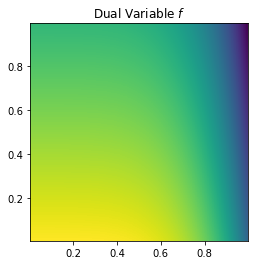

In [2]:
n1, n2 = 128,128
x1 = np.linspace(0,1,n1+1)
x1 = 0.5*(x1[:-1] + x1[1:])

x2 = np.linspace(0,1,n2+1)
x2 = 0.5*(x2[:-1] + x2[1:])

X1, X2 = np.meshgrid(x1,x2)

f = -0.2*X1**5 + 0.1*X2 

plt.imshow(f,extent=(x1[0],x1[-1],x2[0],x2[-1]))
plt.title('Dual Variable $f$')
plt.show()

## Define the source measure 
The source density in this example is uniform over a circular region centered at $c=(0.5,0.5)$.  In particular, the density is given by 
$$
p(x) = \frac{1}{\pi r^2}I\left[\left(x_1-c_1\right)^2 + \left(x_2-c_2\right)^2 <= r^2\right],
$$
where $I[\cdot]$ is an indicator function taking the value $1$ when the argument is true and $0$ otherwise.

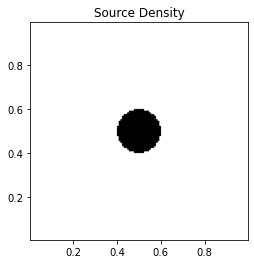

In [3]:
r = 0.1
src_dens = np.zeros(X1.shape)
src_dens[((X1-0.5)**2 + (X2-0.5)**2)<r**2] = 1.0
src_dens *= n1*n2/np.sum(src_dens)

plt.imshow(src_dens,extent=(x1[0],x1[-1],x2[0],x2[-1]),cmap='Greys',origin='lower')
plt.title('Source Density')
plt.show()


## Compute the push forward measure with our approach

In [4]:
noise = 1e-5*np.random.randn(*f.shape)

tgt_dens2 = mmot.push_forward2(f,src_dens, X1,X2)
tgt_dens2_noisy = mmot.push_forward2(f+noise,src_dens, X1,X2)

tgt_dens3 = mmot.push_forward3(f,src_dens,X1,X2)
tgt_dens3_noisy = mmot.push_forward3(f+noise, src_dens, X1, X2)

## Use the push forward function from the original BFM code

In [5]:
bf = BFM(n1, n2, src_dens)
tgt_dens = mmot.push_forward(bf, f, src_dens, X1, X2)
tgt_dens_noisy = mmot.push_forward(bf, f+noise, src_dens, X1, X2)

## Plot the pushforward measures

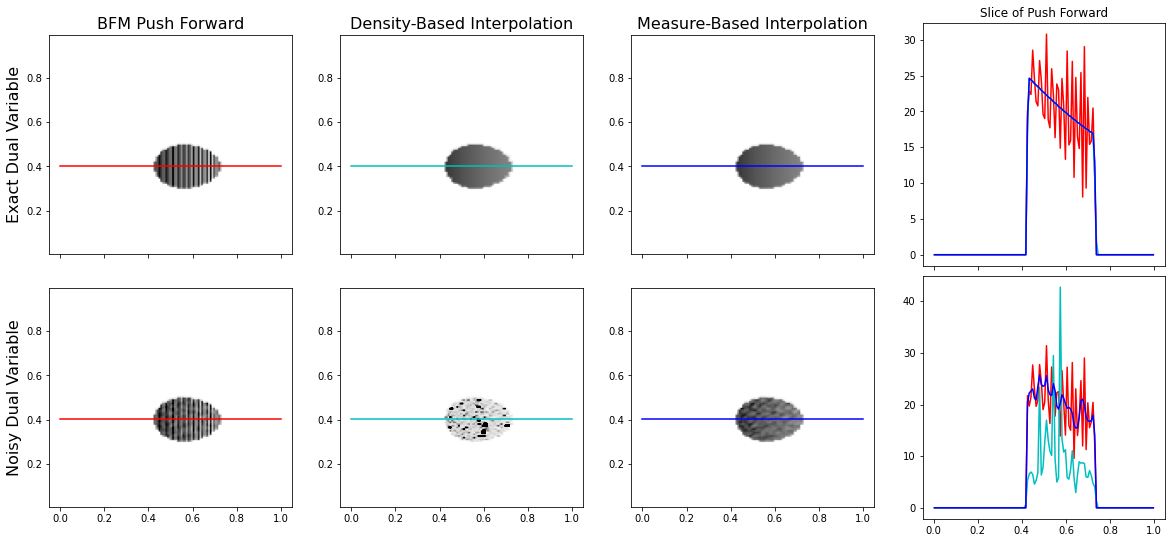

In [6]:

slice_ind = int(0.4*n1)
plot_y = x2[slice_ind]

fig, axs = plt.subplots(figsize=(20,15),ncols=4,nrows=2, sharex=True)

axs[0,0].imshow(tgt_dens,extent=(x1[0],x1[-1],x2[0],x2[-1]),cmap='Greys',origin='lower',vmin=0,vmax=30)
axs[0,0].plot([0,1],[plot_y,plot_y],'r')
axs[0,0].set_title('BFM Push Forward',fontsize=16)
axs[0,0].set_ylabel('Exact Dual Variable',fontsize=16)

axs[1,0].imshow(tgt_dens_noisy,extent=(x1[0],x1[-1],x2[0],x2[-1]),cmap='Greys',origin='lower',vmin=0,vmax=30)
axs[1,0].plot([0,1],[plot_y,plot_y],'r')
axs[1,0].set_ylabel('Noisy Dual Variable',fontsize=16)


axs[0,1].imshow(tgt_dens2,extent=(x1[0],x1[-1],x2[0],x2[-1]),cmap='Greys',origin='lower',vmin=0,vmax=30)
axs[0,1].plot([0,1],[plot_y,plot_y],'c')
axs[0,1].set_title('Density-Based Interpolation',fontsize=16)

axs[1,1].imshow(tgt_dens2_noisy,extent=(x1[0],x1[-1],x2[0],x2[-1]),cmap='Greys',origin='lower',vmin=0,vmax=30)
axs[1,1].plot([0,1],[plot_y,plot_y],'c')


axs[0,2].imshow(tgt_dens3,extent=(x1[0],x1[-1],x2[0],x2[-1]),cmap='Greys',origin='lower',vmin=0,vmax=30)
axs[0,2].plot([0,1],[plot_y,plot_y],'b')
axs[0,2].set_title('Measure-Based Interpolation',fontsize=16)

axs[1,2].imshow(tgt_dens3_noisy,extent=(x1[0],x1[-1],x2[0],x2[-1]),cmap='Greys',origin='lower',vmin=0,vmax=30)
axs[1,2].plot([0,1],[plot_y,plot_y],'b')

axs[0,3].plot(x1, tgt_dens[slice_ind,:],'r', label='BFM')
axs[0,3].plot(x1, tgt_dens2[slice_ind,:],'c', label='Density Interpolated')
axs[0,3].plot(x1, tgt_dens3[slice_ind,:],'b', label='Measure Interpolated')
axs[0,3].set_title('Slice of Push Forward')
axs[0,3].set_aspect(1./axs[0,3].get_data_ratio())

axs[1,3].plot(x1, tgt_dens_noisy[slice_ind,:],'r', label='BFM')
axs[1,3].plot(x1, tgt_dens2_noisy[slice_ind,:],'c', label='Density Interpolated')
axs[1,3].plot(x1, tgt_dens3_noisy[slice_ind,:],'b', label='Measure Interpolated')
axs[1,3].set_aspect(1./axs[1,3].get_data_ratio())

plt.subplots_adjust(hspace=-0.55)

plt.savefig('PushForwardComparison.pdf',bbox_inches='tight')
plt.show()

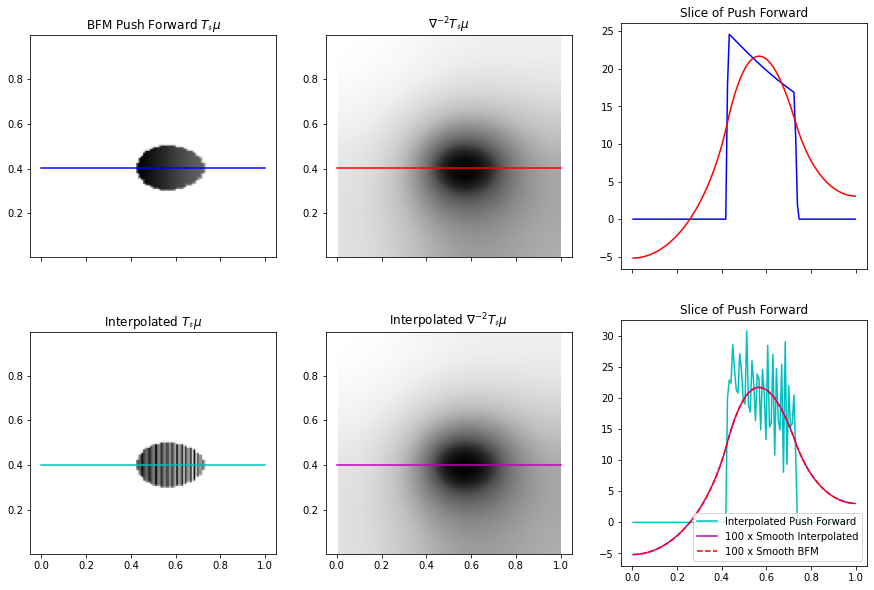

In [7]:
def FilterSignal(image):
    coeffs = dctn(image, norm='ortho')
    coeffs[40:,:] = 0
    coeffs[:,40:] = 0

    xx, yy = np.meshgrid(np.linspace(0,np.pi,n1,False), np.linspace(0,np.pi,n2,False))
    kernel = 2*n1*n1*(1-np.cos(xx)) + 2*n2*n2*(1-np.cos(yy))
    kernel[0,0] = 1     # to avoid dividing by zero
    
    workspace = dctn(image,norm='ortho') / kernel
    workspace[0,0] = 0
    workspace = idctn(workspace, norm='ortho')
    
    return workspace

new_dens = FilterSignal(tgt_dens)
new_dens2 = FilterSignal(tgt_dens2)

fig, axs = plt.subplots(figsize=(15,10),ncols=3, nrows=2, sharex=True)

axs[0,0].imshow(tgt_dens,extent=(x1[0],x1[-1],x2[0],x2[-1]),cmap='Greys',origin='lower')
axs[0,0].plot([0,1],[plot_y,plot_y],'b')
axs[0,0].set_title('BFM Push Forward $T_\sharp\mu$')

axs[0,1].imshow(new_dens,extent=(x1[0],x1[-1],x2[0],x2[-1]),cmap='Greys',origin='lower')
axs[0,1].set_title('$\\nabla^{-2} T_\sharp\mu$')
axs[0,1].plot([0,1],[plot_y,plot_y],'r')


axs[0,2].plot(x1, tgt_dens[slice_ind,:],'b', label='BFM')
axs[0,2].plot(x1, 100*new_dens2[slice_ind,:],'r', label='100 x Smoothed')
axs[0,2].set_title('Slice of Push Forward')
axs[0,2].set_aspect(1./axs[0,2].get_data_ratio())


axs[1,0].imshow(tgt_dens2,extent=(x1[0],x1[-1],x2[0],x2[-1]),cmap='Greys',origin='lower')
axs[1,0].plot([0,1],[plot_y,plot_y],'c')
axs[1,0].set_title('Interpolated $T_\sharp\mu$')

axs[1,1].imshow(new_dens2,extent=(x1[0],x1[-1],x2[0],x2[-1]),cmap='Greys',origin='lower')
axs[1,1].set_title('Interpolated $\\nabla^{-2} T_\sharp\mu$')
axs[1,1].plot([0,1],[plot_y,plot_y],'m')


axs[1,2].plot(x1, tgt_dens2[slice_ind,:],'c', label='Interpolated Push Forward')
axs[1,2].plot(x1, 100*new_dens2[slice_ind,:],'m', label='100 x Smooth Interpolated')
axs[1,2].plot(x1, 100*new_dens[slice_ind,:],'--r', label='100 x Smooth BFM')
axs[1,2].set_title('Slice of Push Forward')
axs[1,2].set_aspect(1./axs[1,2].get_data_ratio())

plt.legend(loc=4)

plt.savefig('SmoothPushforward.pdf',bbox_inches='tight')
